In [1]:
%matplotlib nbagg

In [2]:
import processing
import numpy as np
import hyperspy.api as hs

/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
stackheight = 8

In [4]:
def _make_circular_mask(centerX, centerY, imageSizeX, imageSizeY, radius):
    """
    Make a circular mask in a bool array for masking a region in an image.

    Parameters
    ----------
    centreX, centreY : float
        Centre point of the mask.
    imageSizeX, imageSizeY : int
        Size of the image to be masked.
    radius : float
        Radius of the mask.

    Returns
    -------
    Boolean Numpy 2D Array
        Array with the shape (imageSizeX, imageSizeY) with the mask.

    Examples
    --------
    >>> import numpy as np
    >>> import fpd_data_processing.pixelated_stem_tools as pst
    >>> image = np.ones((9, 9))
    >>> mask = pst._make_circular_mask(4, 4, 9, 9, 2)
    >>> image_masked = image*mask
    >>> import matplotlib.pyplot as plt
    >>> cax = plt.imshow(image_masked)
    """
    x, y = np.ogrid[-centerY:imageSizeY-centerY, -centerX:imageSizeX-centerX]
    mask = x*x + y*y <= radius*radius
    return(mask)

In [5]:
ds = processing.BinaryHDFSDataSet(index_path="test/index.json", host='localhost', port=8020, stackheight=stackheight)

job = processing.ApplyMasksJob(dataset=ds, masks=[
    np.random.randn(128, 128),
    np.ones(shape=(128, 128)) * _make_circular_mask(
        centerX=64, centerY=64,
        imageSizeX=128, imageSizeY=128, radius=15
    ),
    np.ones(shape=(128, 128)) * _make_circular_mask(
        centerX=64, centerY=64,
        imageSizeX=128, imageSizeY=128, radius=25
    ),
    np.ones(shape=(128, 128)) * _make_circular_mask(
        centerX=64, centerY=64,
        imageSizeX=128, imageSizeY=128, radius=50
    ),
    np.ones(shape=(128, 128)) * (
        _make_circular_mask(
            centerX=64, centerY=64,
            imageSizeX=128, imageSizeY=128, radius=50
        ) &
        (~_make_circular_mask(
            centerX=64, centerY=64,
            imageSizeX=128, imageSizeY=128, radius=45
        ))
    ),
])

executor = processing.DaskJobExecutor(scheduler_uri="tcp://localhost:8786")
# print(executor.client.scheduler_info())

<IPython.core.display.Javascript object>


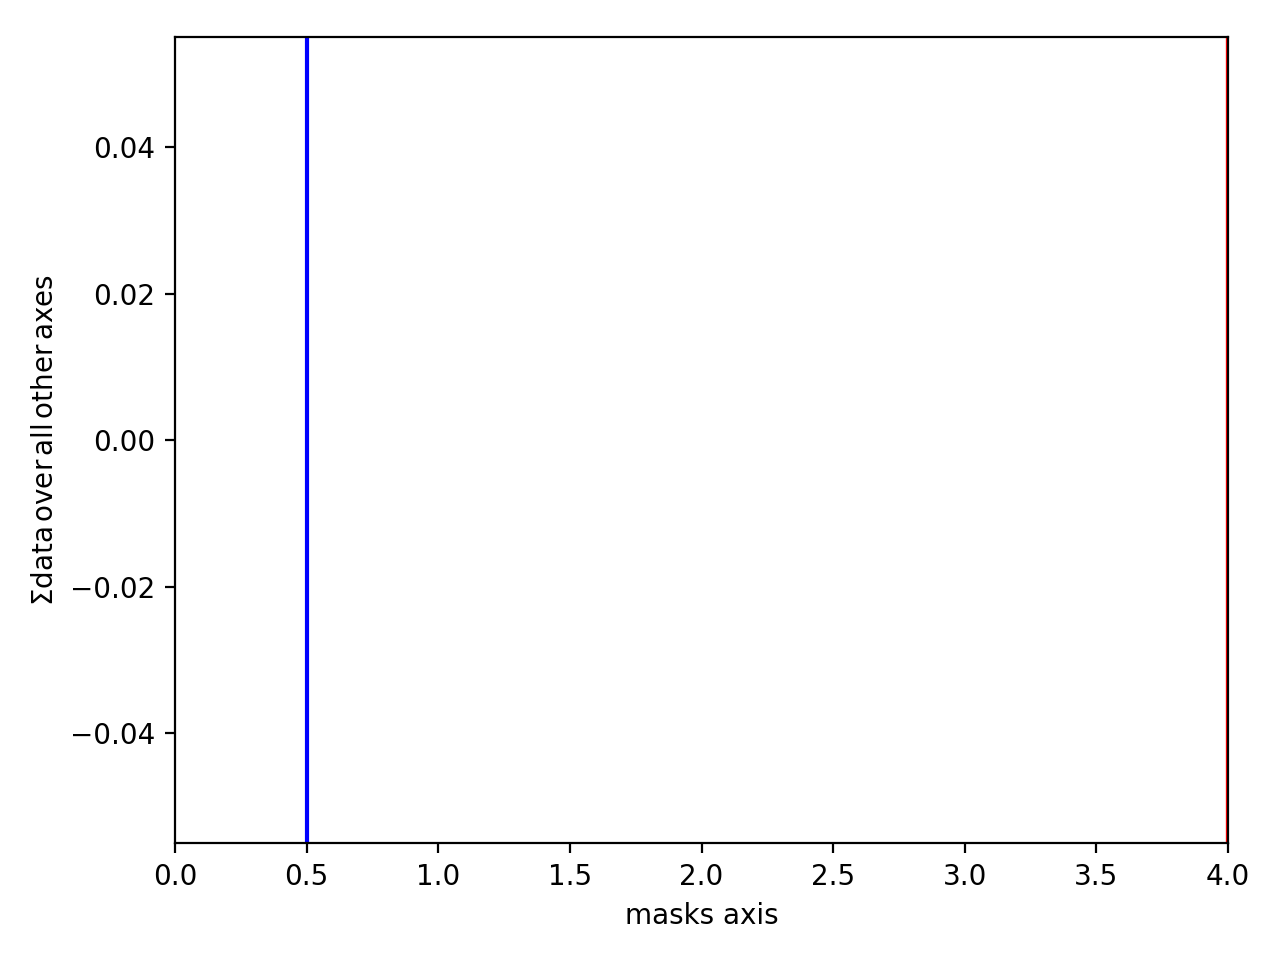

<IPython.core.display.Javascript object>


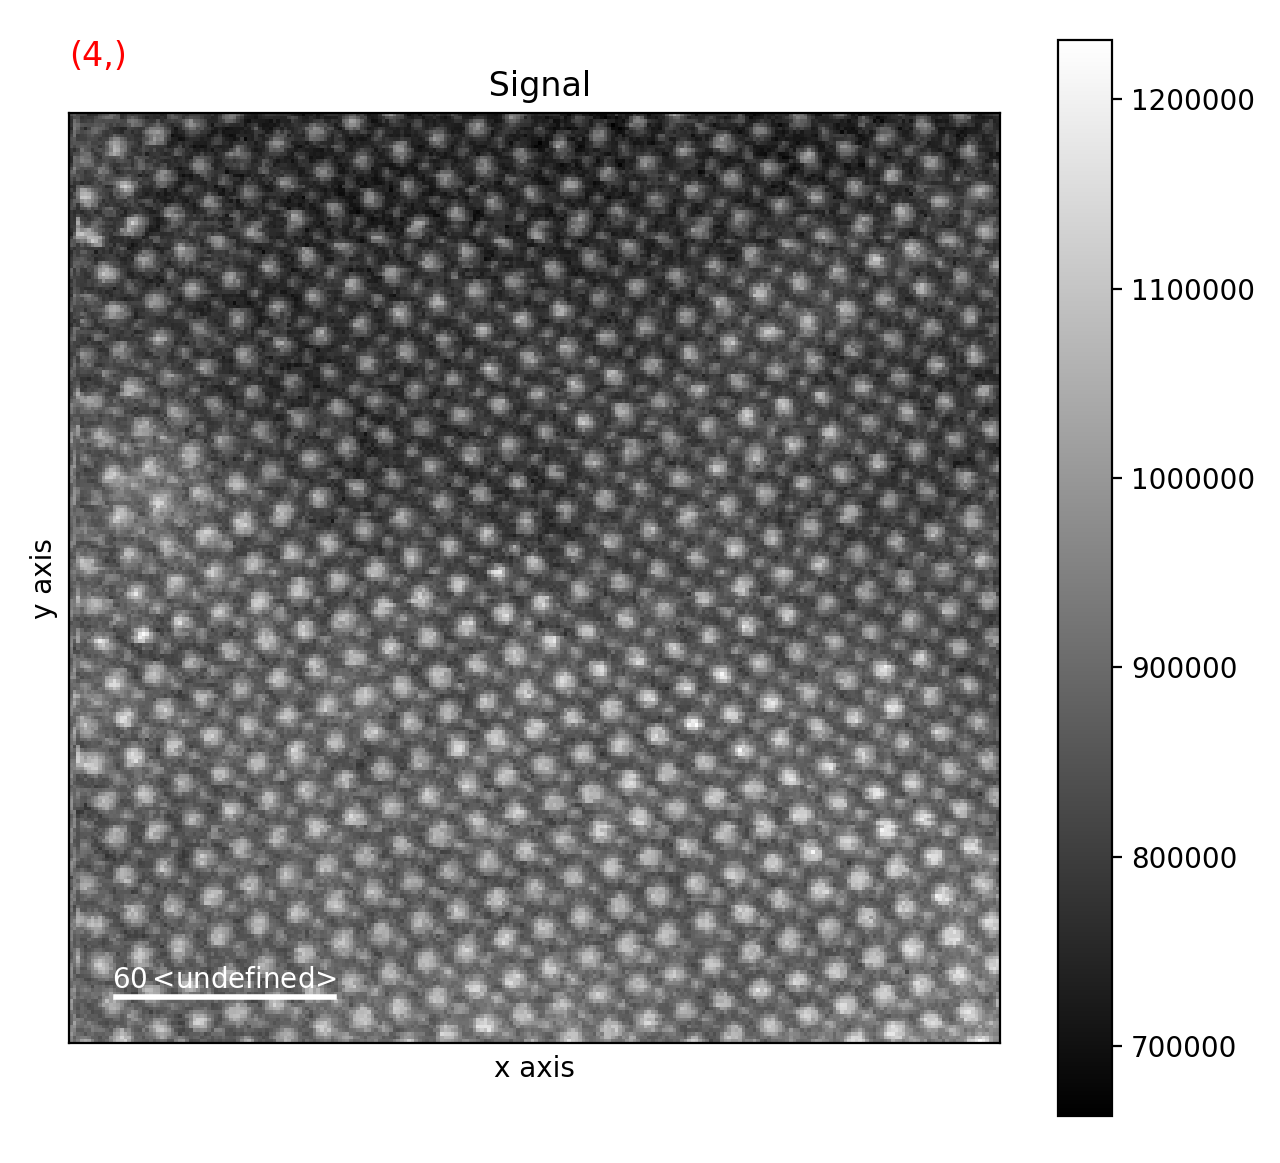

In [6]:
full_result = hs.signals.Signal2D(np.zeros(shape=(job.maskcount, 256, 256)))
full_result.axes_manager[0].name = "masks"
full_result.axes_manager[1].name = "x"
full_result.axes_manager[2].name = "y"
full_result.plot()
full_result.axes_manager.gui_navigation_sliders()

In [10]:
# stuff = hs.interactive(lambda axis: 0, axis=0)  # do some post procesing
def run():
    for result in executor.run_job(job):
        for tile in result:
            tile.save_to_result(full_result.data)
        full_result.events.data_changed.trigger(full_result)
    return tile
%time tile = run()

CPU times: user 598 ms, sys: 29.5 ms, total: 627 ms
Wall time: 1.44 s


<IPython.core.display.Javascript object>


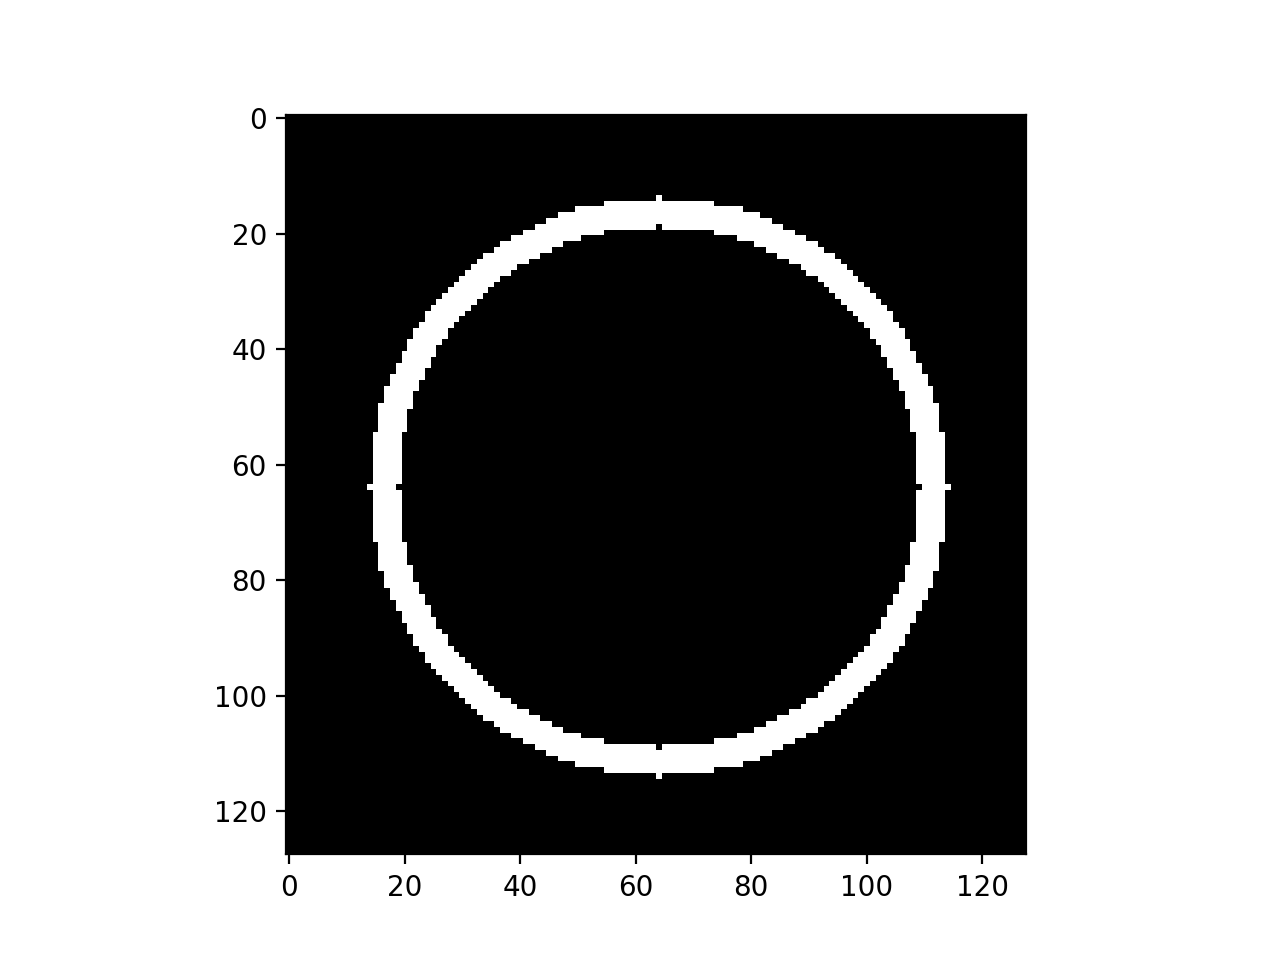

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
cax = axes.imshow(job.orig_masks[4])

In [9]:
job.orig_masks[4].shape

(128, 128)

In [14]:
tile.tile_slice.

(slice(255, 256, None),
 slice(248, 256, None),
 slice(0, 128, None),
 slice(0, 128, None))